In [36]:
import re
import uuid
import pickle
from unicodedata import normalize
from string import punctuation
import warnings
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import spacy
import nltk
from nltk.cluster import KMeansClusterer
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import homogeneity_completeness_v_measure, silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN, OPTICS, KMeans
import hdbscan
from pyclustering.cluster.xmeans import xmeans, kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.elbow import elbow
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from IPython.display import HTML

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

warnings.filterwarnings('ignore')
np.random.seed(123456)

%matplotlib inline

In [79]:
def euclidian(a, b, axis=-1):
    return np.sqrt(np.sum(np.square(a - b), axis=axis))

def make_colors(y_train, cluster_labels, colors):  
    cl_train = colors[:len(set(y_train))]
    cl_cluster = colors[:len(set(cluster_labels))]
    c_y_train = [cl_train[y] if y >= 0 else [0.50196078, 0.50196078, 0.50196078] for y in y_train]
    c_y_cluster = [cl_cluster[y] if y >= 0 else [0.50196078, 0.50196078, 0.50196078] for y in cluster_labels]
    return c_y_train, c_y_cluster

def join_cluster(X, cluster_labels):
    max_cluster_label = np.max(cluster_labels)
    idx = np.where(cluster_labels == -1)
    X_org = X[np.where(cluster_labels != -1)]
    for x in idx[0]:
        sim = np.round(1 - cosine_similarity([X[x]], X_org), 3).ravel()
        dcs = np.where(sim <= 0.6)
        it = 0.65
        while len(dcs[0]) == 0:
            dcs = np.where(sim <= it)
            it += 0.05
        original_label = y_train[dcs[0][0]]
        cluster_labels[idx] = original_label if original_label <= max_cluster_label else max_cluster_label + 1
    return cluster_labels

def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = re.sub(r'["\'@#%\(\)$0-9]', " ", phrase)
    phrase = NLP(re.sub(r'[-+=:]', "", phrase), disable=["parser"])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != "PUNCT":
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                try:
                    word = VERBOS[word]
                except:
                    word = palavra.lemma_
                clean_frase += [remover_acentos(word)]
                # clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
    return clean_frase

def _get_stopwords():
    stpwords = sorted(list(set(stopwords.words('portuguese') + list(NLP.Defaults.stop_words) + list(punctuation))))
    rms = ["um", "uma", "não", "mais", "muito", "você"]
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

# NLP = spacy.load("pt")
# STEMMER = nltk.stem.RSLPStemmer()
NLP = spacy.load('pt_core_news_sm')
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

VERBOS = {}
with open("datasets/verbs.pkc", "rb") as infile:
    verbos = pickle.load(infile)
    for verb in verbos:
        for v in list(verb.values())[0]:
            VERBOS[v] = list(verb.keys())[0]
    
colors = np.asarray([
    (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240),
    (240, 50, 230), (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200),
    (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0),
    (141, 204, 226), (212, 50, 147), (251, 226, 93), (16, 185, 176), (189, 182, 163), (244, 172, 18), (100, 28, 112),
    (165, 124, 92), (183, 160, 211), (66, 47, 105), (240, 67, 7), (244, 188, 198),
    
    (249, 235, 234), (242, 215, 213), (230, 176, 170), (217, 136, 128), (205, 97, 85), (192, 57, 43), (169, 50, 38), 
    (146, 43, 33), (123, 36, 28), (100, 30, 22), (253, 237, 236), (250, 219, 216), (245, 183, 177), (241, 148, 138), 
    (236, 112, 99), (231, 76, 60), (203, 67, 53), (176, 58, 46), (148, 49, 38), (120, 40, 31), (245, 238, 248), (235, 222, 240), 
    (215, 189, 226), (195, 155, 211), (175, 122, 197), (155, 89, 182), (136, 78, 160), (118, 68, 138), (99, 57, 116), (81, 46, 95), 
    (244, 236, 247), (232, 218, 239), (210, 180, 222), (187, 143, 206), (165, 105, 189), (142, 68, 173), (125, 60, 152), 
    (108, 52, 131), (91, 44, 111), (74, 35, 90), (234, 242, 248), (212, 230, 241), (169, 204, 227), (127, 179, 213), (84, 153, 199), 
    (41, 128, 185), (36, 113, 163), (31, 97, 141), (26, 82, 118), (21, 67, 96), (235, 245, 251), (214, 234, 248), (174, 214, 241), 
    (133, 193, 233), (93, 173, 226), (52, 152, 219), (46, 134, 193), (40, 116, 166), (33, 97, 140), (27, 79, 114), (232, 248, 245), 
    (209, 242, 235), (163, 228, 215), (118, 215, 196), (72, 201, 176), (26, 188, 156), (23, 165, 137), (20, 143, 119), (17, 120, 100), 
    (14, 98, 81), (232, 246, 243), (208, 236, 231), (162, 217, 206), (115, 198, 182), (69, 179, 157), (22, 160, 133), (19, 141, 117), 
    (17, 122, 101), (14, 102, 85), (11, 83, 69), (233, 247, 239), (212, 239, 223), (169, 223, 191), (125, 206, 160), (82, 190, 128), 
    (39, 174, 96), (34, 153, 84), (30, 132, 73), (25, 111, 61), (20, 90, 50), (234, 250, 241), (213, 245, 227), (171, 235, 198), 
    (130, 224, 170), (88, 214, 141), (46, 204, 113), (40, 180, 99), (35, 155, 86), (29, 131, 72), (24, 106, 59), (254, 249, 231), 
    (252, 243, 207), (249, 231, 159), (247, 220, 111), (244, 208, 63), (241, 196, 15), (212, 172, 13), (183, 149, 11), (154, 125, 10), 
    (125, 102, 8), (254, 245, 231), (253, 235, 208), (250, 215, 160), (248, 196, 113), (245, 176, 65), (243, 156, 18), (214, 137, 16), 
    (185, 119, 14), (156, 100, 12), (126, 81, 9), (253, 242, 233), (250, 229, 211), (245, 203, 167), (240, 178, 122), (235, 152, 78), 
    (230, 126, 34), (202, 111, 30), (175, 96, 26), (147, 81, 22), (120, 66, 18), (251, 238, 230), (246, 221, 204), (237, 187, 153), 
    (229, 152, 102), (220, 118, 51), (211, 84, 0), (186, 74, 0), (160, 64, 0), (135, 54, 0), (110, 44, 0), (253, 254, 254), 
    (251, 252, 252), (247, 249, 249), (244, 246, 247), (240, 243, 244), (236, 240, 241), (208, 211, 212), (179, 182, 183), 
    (151, 154, 154), (123, 125, 125), (248, 249, 249), (242, 243, 244), (229, 231, 233), (215, 219, 221), (202, 207, 210), 
    (189, 195, 199), (166, 172, 175), (144, 148, 151), (121, 125, 127), (98, 101, 103), (244, 246, 246), (234, 237, 237), 
    (213, 219, 219), (191, 201, 202), (170, 183, 184), (149, 165, 166), (131, 145, 146), (113, 125, 126), (95, 106, 106), 
    (77, 86, 86), (242, 244, 244), (229, 232, 232), (204, 209, 209), (178, 186, 187), (153, 163, 164), (127, 140, 141), 
    (112, 123, 124), (97, 106, 107), (81, 90, 90), (66, 73, 73), (235, 237, 239), (214, 219, 223), (174, 182, 191), (133, 146, 158), 
    (93, 109, 126), (52, 73, 94), (46, 64, 83), (40, 55, 71), (33, 47, 60), (27, 38, 49), (234, 236, 238), (213, 216, 220), 
    (171, 178, 185), (128, 139, 150), (86, 101, 115), (44, 62, 80), (39, 55, 70), (33, 47, 61), (28, 40, 51), (23, 32, 42), 
    (205, 92, 92), (240, 128, 128), (250, 128, 114), (233, 150, 122), (255, 160, 122), (255, 255, 255), (192, 192, 192), 
    (128, 128, 128), (0, 0, 0), (255, 0, 0), (128, 0, 0), (255, 255, 0), (128, 128, 0), (0, 255, 0), (0, 128, 0), (0, 255, 255), 
    (0, 128, 128), (0, 0, 255), (0, 0, 128), (255, 0, 255), (128, 0, 128)
]).astype(np.float32) / 255.0

### Carregamento dos datasets

Os datasets de exemplos são frases já pré-categorizadas usadas em chatbots.

Contém 33 categorias e ao todo 696 documentos ou frases.

In [89]:
dataset = 3

if dataset == 1:
    df_data = pd.read_csv("datasets/intents.csv", sep=';', names=["cluster", "perguntas"])
    df_data = df_data[df_data.columns[::-1]]
    df_data.dropna(inplace=True)
    df_data['cluster'] = df_data['cluster'].str.upper()
elif dataset == 2:
    df_data = pd.read_csv("datasets/ground_truth.csv", sep=';', names=["perguntas", "cluster"])
    df_data.dropna(inplace=True)
    df_data['cluster'] = df_data['cluster'].str.upper()
else:
    df_data1 = pd.read_csv("datasets/intents.csv", sep=';', names=["cluster", "perguntas"])
    df_data2 = pd.read_csv("datasets/ground_truth.csv", sep=';', names=["perguntas", "cluster"])

    df_data1 = df_data1[df_data1.columns[::-1]]
    df_data = pd.concat([df_data1, df_data2], sort=False)
    df_data.dropna(inplace=True)
    df_data['cluster'] = df_data['cluster'].str.upper()

T = df_data.to_numpy()
index = np.random.choice(T.shape[0], 10, replace=False)
display(df_data.iloc[index].sort_values(by=["cluster"]))

c = np.argmax(pd.get_dummies(df_data["cluster"]).to_numpy(), axis=1)

N = df_data["cluster"].to_numpy().shape[0]
clusters = len(set(c))
colors_ = colors[range(0, clusters)]

,perguntas,cluster
90,Ativar o serviço de mensagem de voz,ADD_SERVICE_FEATURES
181,Atualizar para um novo telefone,DEVICE_UPGRADE_ELIGIBILITY
215,As tarifas internacionais são calculadas por minutos ou por chamadas individuais?,INTERNATIONAL_RATE_PLAN_INQUIRY
224,Existe alguma interrupção no sinal? estou sem cobertura.,NETWORK_COMPLAINTS
43,a senha esta inválida ou incorreta,PASSWORD
351,Por que sua loja não aceita o meu retorno?,RETURN_DEVICE
12,pra que voce serve?,SERVICES
79,muito obrigado mesmo,THANK_YOU
88,"valeu mesmo, obrigado",THANK_YOU
64,como eu faco para configurar a rede sem fio (wifi)?,WIFI


In [90]:
uniq, cnt = np.unique(np.asarray(df_data["cluster"]), return_counts=True)
df_org = pd.DataFrame(np.array(list(zip(uniq, cnt))), columns=["Categoria", "Qtde"])

print("Qtde. de documentos por categoria:")
display(df_org.sort_values(by=["Categoria"]))

Qtde. de documentos por categoria:


,Categoria,Qtde
0,ACCOUNT,29
1,ACTIVATE_DEVICE,19
2,ACTIVATE_PREPAID_PLAN,21
3,ACTIVATE_ROAMING,20
4,ADD_INSURANCE,18
5,ADD_SERVICE_FEATURES,20
6,BOT_FOUND,20
7,BOT_NAME,16
8,CERTIFICATE,18
9,CHANGE_PRICE_PLAN,19


In [91]:
X_train, X_test, y_train, y_test = train_test_split(df_data["perguntas"], c, test_size=0.2)

qtde_docs = len(df_data["perguntas"])
qtde_categ = len(df_data["cluster"])
print(f"Total docs     : {qtde_docs}")
print(f"Total cluster  : {qtde_categ}")
print(f"X_train size   : {X_train.shape}")
print(f"X_test  size   : {X_test.shape}")

Total docs     : 690
Total cluster  : 690
X_train size   : (552,)
X_test  size   : (138,)


### Dataset tokenization

In [92]:
P = X_train.shape[0]
print("Tokenization...")
documents_d2c = [TaggedDocument(tokenizer(doc), [i]) for i, doc in enumerate(X_train)]
print("Qtd documentos treino: ", len(documents_d2c))
print("Qtd Intents treino   : ", len(np.unique(df_data["cluster"].to_numpy())))
print("Finished...")

Tokenization...
Qtd documentos treino:  552
Qtd Intents treino   :  32
Finished...


In [93]:
documents_d2c[:10]

[TaggedDocument(words=['trocar', 'um', 'aparelhar'], tags=[0]),
 TaggedDocument(words=['servicos', 'voce', 'oferecer'], tags=[1]),
 TaggedDocument(words=['pessoa', 'chamar'], tags=[2]),
 TaggedDocument(words=['certar', 'partir', 'cidade', 'nao', 'sinal', 'poder', 'motivar'], tags=[3]),
 TaggedDocument(words=['telefonar', 'exterior', 'feria', 'tarifar'], tags=[4]),
 TaggedDocument(words=['nao'], tags=[5]),
 TaggedDocument(words=['servico', 'disponivel'], tags=[6]),
 TaggedDocument(words=['consultar', 'outro', 'informacao', 'voce'], tags=[7]),
 TaggedDocument(words=['um', 'cliente', 'longo', 'prazo', 'voce', 'desconto', 'receber', 'cobranca'], tags=[8]),
 TaggedDocument(words=['ajudar', 'ativacao', 'telefonar', 'prepago'], tags=[9])]

### **Doc2Vec**

Parâmetros iniciais... quantidade de dimensões dos vetores gerados para cada frase, épocas de treinamento e épocas de posterior inferência para novas frases.

A quantidade de épocas de inferência, sugere-se ser bem superior as de treinamento.

In [94]:
kmin = 5
kmax = 40
dim = 500
epochs = 200
M = 15000

print(f"Dimensions   : {dim}")
print(f"Epochs       : {epochs}")
print(f"Infer Epochs : {M}")

Dimensions   : 500
Epochs       : 200
Infer Epochs : 15000


In [95]:
print("Starting model...")
common_kwargs = dict(
    dm=0, vector_size=dim, epochs=epochs, workers=cpu_count(), 
    window=10, min_count=2, alpha=1e-2, min_alpha=1e-4,
    hs=1, negative=7, dbow_words=1, sample=0
)
d2v = Doc2Vec(**common_kwargs)
print("Building vocab...")
d2v.build_vocab(documents_d2c)
print("Training...")
d2v.train(
    documents_d2c,
    total_examples=d2v.corpus_count,
    epochs=d2v.epochs
)
print("Finish...")

Starting model...
Building vocab...
Training...
Finish...


Validação do modelo gerado pelo Doc2Vec... teste tanto nos dados apresentados para treinamento quanto nos dados de testes e as acurácias alcançadas.

### Acurácia distância cossenoidal

In [96]:
T = 100 if X_train.shape[0] > 100 else X_train.shape[0]

def validate(xt):
    new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
    sim = d2v.docvecs.most_similar(positive=[new_doc_vec], topn=1)
    return xt[1] == y_train[sim[0][0]]

dc = np.c_[X_train, y_train]
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    elms = utils.shuffle([doc for doc in dc], n_samples=T)
    acc = list(exc.map(validate, elms, chunksize=10))
    print("- Acurácia treino:", np.round(np.mean(acc) * 100, 2))

def validate(xt):
    new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
    sim = np.array(d2v.docvecs.most_similar(positive=[new_doc_vec], topn=15))
    unq, cnt = np.unique(y_train[sim[:, 0].astype(np.int32)], return_counts=True)
    if unq[np.where(cnt == np.max(cnt))[0][0]] == y_train[sim[0][0].astype(np.int32)]:
        return xt[1] == y_train[sim[0][0].astype(np.int32)]
    return xt[1] == unq[np.where(cnt == np.max(cnt))[0][0]]

accc = []
T = 100 if X_test.shape[0] > 100 else X_test.shape[0]
dc = np.c_[X_test, y_test]
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    for p in range(5):
        elms = utils.shuffle([doc for doc in dc], n_samples=T)
        acc = list(exc.map(validate, elms, chunksize=10))
        print(f" - Acurácia teste {p+1}  :", np.round(np.mean(acc) * 100, 2))
        accc += acc
print("- Acurácia média teste:", np.round(np.mean(accc) * 100, 2))

- Acurácia treino: 100.0
 - Acurácia teste 1  : 54.0
 - Acurácia teste 2  : 56.0
 - Acurácia teste 3  : 53.0
 - Acurácia teste 4  : 57.0
 - Acurácia teste 5  : 55.0
- Acurácia média teste: 55.0


### Acurácia distância euclidiana

In [97]:
T = 100 if X_train.shape[0] > 100 else X_train.shape[0]

def validate_euclidian(xt):
    new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
    sim = euclidian([new_doc_vec], d2v.docvecs.vectors_docs)
    sim = np.where(sim == np.min(sim))
    return xt[1] == y_train[sim[0][0]]

dc = np.c_[X_train, y_train]
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    elms = utils.shuffle([doc for doc in dc], n_samples=T)
    acc = list(exc.map(validate_euclidian, elms, chunksize=10))
    print("- Acurácia treino:", np.round(np.mean(acc) * 100, 2))

def validate_euclidian(xt):
    new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
    sim = euclidian([new_doc_vec], d2v.docvecs.vectors_docs)
    sim = np.where(sim == np.min(sim))
    return xt[1] == y_train[sim[0][0].astype(np.int32)]

accc = []
T = 100 if X_test.shape[0] > 100 else X_test.shape[0]
dc = np.c_[X_test, y_test]
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    for p in range(5):
        elms = utils.shuffle([doc for doc in dc], n_samples=T)
        acc = list(exc.map(validate_euclidian, elms, chunksize=10))
        print(f" - Acurácia teste {p+1}  :", np.round(np.mean(acc) * 100, 2))
        accc += acc
print("- Acurácia média teste:", np.round(np.mean(accc) * 100, 2))

- Acurácia treino: 100.0
 - Acurácia teste 1  : 55.0
 - Acurácia teste 2  : 57.0
 - Acurácia teste 3  : 56.0
 - Acurácia teste 4  : 54.0
 - Acurácia teste 5  : 55.0
- Acurácia média teste: 55.4


### Clusterização

Utilizou-se o KMeans definindo a quantidade de clusters para o número ideal de categorias existentes no caso 33. A métrica de distância utilizada, não foi a euclidiana, mas sim a de cosseno (métrica comumente usada na classificação de texto em seu espaço vetorial).

In [11]:
X = d2v.docvecs.vectors_docs

def find_similar(doc):
    return d2v.infer_vector(tokenizer(doc), epochs=M)

with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    XT = np.array(list(exc.map(find_similar, X_test, chunksize=25)))

In [12]:
kclusterer = KMeansClusterer(
    clusters,
    distance=cosine_distance,
    initial_means=utils.shuffle(X, n_samples=clusters).tolist(),
    avoid_empty_clusters=True
)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [13]:
docs = np.asarray(X_train)

info = []
frases = []
for i in range(clusters):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(clusters)], np.asarray(info)[:, 1]])

print("Frases por cluster:")
data = []
for i in range(clusters):
    T = df.to_numpy()
    data += utils.shuffle(T[T[:, 1] == i], n_samples=3).tolist()
df = pd.DataFrame(data, columns=["title", "cluster"])
display(HTML(df.sort_values(by=["cluster"]).to_html(index=False)))

print("-" * 20)
print("Documentos por cluster:")
display(HTML(df_inf.to_html(index=False, header=False)))

Frases por cluster:


title,cluster
Existe a possibilidade de ter o meu dispositivo de telefone de alguma forma assegurado?,0
Eu vou estar viajando e estou certo se minha empresa fornece cobertura de telefone na minha área de viagens. Poderia me dar informaçÃµes sobre onde o serviço e recepção estará disponível?,0
Quanto da área total no meu país é coberta pela recepção?,0
Qual é o mais recente plano 4G adequado para mim como um pacote família?,1
Gostaria de adicionar o MMS ao meu pacote.,1
Eu tenho um plano com outra empresa. Posso manter meu número?,1
Posso excluir o envio de sms?,2
Eu gostaria de cancelar o serviço de encaminhamento das minhas ligações. Como faço isso?,2
Você pode me dizer a tarifa atual de cobrança da Europa Continental para o Reino Unido do meu telefone?,2
Como cancelo meu serviço de telefone pré-pago?,3


--------------------
Documentos por cluster:


C0,13
C1,8
C2,6
C3,31
C4,19
C5,8
C6,13
C7,13
C8,28
C9,11
C10,22


### Visualização

Apresentação dos protótipos gerados pelo KMeans, reduzindo a dimensão usando o algoritmo MDS (Multidimensional Scaling).

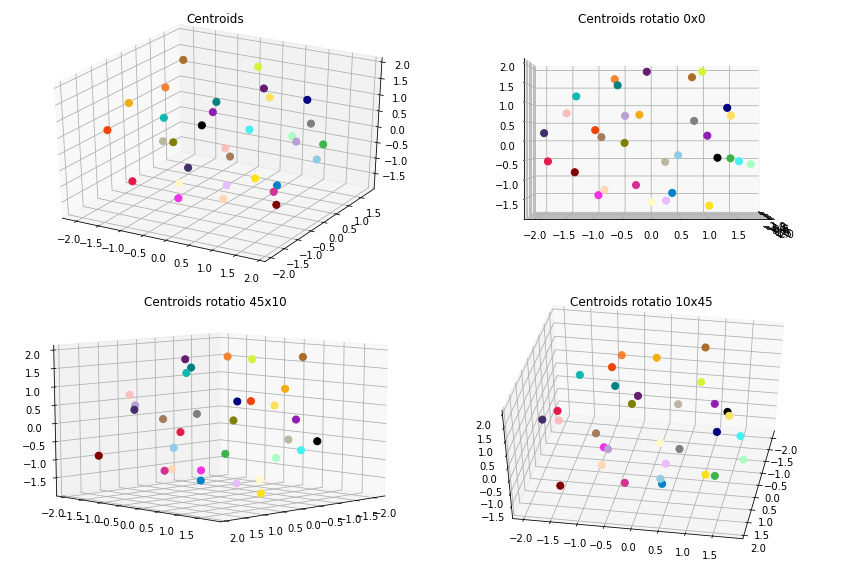

In [14]:
mds = MDS(
    n_components=3,
    n_init=5,
    max_iter=500,
    random_state=0,
    n_jobs=-1
)
X_cnt = mds.fit_transform(centroids)

plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title("Centroids")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors_, alpha=1, s=50)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title("Centroids rotatio 0x0")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors_, alpha=1, s=50)
ax.view_init(0, 0)
ax = plt.subplot(2, 2, 3, projection='3d')
plt.title("Centroids rotatio 45x10")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors_, alpha=1, s=50)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 4, projection='3d')
plt.title("Centroids rotatio 10x45")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors_, alpha=1, s=50)
ax.view_init(45, 10)
plt.tight_layout()
plt.show()

### Clusterização dos dados de Teste

Por fim, realizada a clusterização dos dados de teste e a apresentação das 8 primeiras frases do conjunto de teste juntamente com outras duas frases do cluster ao qual foi identificado como o melhor.

In [15]:
Xtest = X_test.to_numpy()
for i, xt in enumerate(XT[:8]):
    clt = kclusterer.classify(xt)
    print("*", Xtest[i])
    for frase in utils.shuffle(df[df["cluster"] == clt].to_numpy(), n_samples=2):
        print("  - ", frase[0])
    print("-" * 20)

* Se eu ativar roaming agora, já posso utilizar?
  -  utilizar o acesso remoto via vpn
  -  how to configure vpn?
--------------------
* Fui assaltado, preciso acionar seguro.
  -  Como trocar um plano de conversação direta para um telefone desta operadora gratuitamente?
  -  Oi, eu preciso de um seguro para o meu telefone, quais são as opções disponíveis para o meu plano?
--------------------
* Estou bastante cansado do meu telefone existente e gostaria de saber quando eu vou ser elegível para sua atualização?
  -  Como faço para transferir o serviço de um dispositivo antigo para um novo?
  -  Eu não sei como desbloquear o meu novo dispositivo. Pode me dizer como?
--------------------
* Oi, como posso ativar o encaminhamento de chamada no meu plano?
  -  Remover o encaminhamento de chamada
  -  Quais servicos posso remover diretamente pelo meu aparelho?
--------------------
* Eu não consigo acessar meu email
  -  Não consigo iniciar o bluetooth para emparelhar com o fone de ouvido, o 

### Métricas

Abaixo são apresentadas métricas para demonstrar o quanto a clusterização parece funcionar.

In [16]:
hom, compl, v_measure = homogeneity_completeness_v_measure(y_test, [kclusterer.classify(xt) for xt in XT])
silh = silhouette_score(XT, labels=[kclusterer.classify(xt) for xt in XT], metric="cosine", random_state=0)

print("Homogeneidade    : ", np.round(hom, 3))
print("Completude       : ", np.round(compl, 3))
print("V-Measure        : ", np.round(v_measure, 3))
print("Silhouette       : ", np.round(silh, 3))

Homogeneidade    :  0.668
Completude       :  0.687
V-Measure        :  0.678
Silhouette       :  0.004


Como exemplo de comparação, foi executado o mesmo algoritmo de clusterização (conforme apresentado acima) entretanto variando a quantidade do número de clusters para verificar como as métricas se comportam.

In [17]:
def multi_kmeans(Xtf, k):
    error = True
    while error:
        try:
            initial_means = utils.shuffle(Xtf, n_samples=k).tolist()
            kclusterer_ = KMeansClusterer(
                k,
                initial_means=initial_means,
                distance=cosine_distance,
                avoid_empty_clusters=True
            )
            assigned_clusters = kclusterer_.cluster(Xtf, assign_clusters=True)
            error = False
        except:
            pass
    hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, assigned_clusters)
    silh = silhouette_score(Xtf, labels=assigned_clusters, metric="cosine", random_state=0)
    return {"K": k, "HOM": hom, "COMPL": compl, "VM": v_measure, "SILH": silh}

clusterizacao = []
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    results = list(exc.map(partial(multi_kmeans, X), range(kmin, kmax), chunksize=10))
    for r in results:   
        clusterizacao.append({
            "Qtd. Cluster": r["K"],
            "Homogeneity": np.round(r["HOM"], 3),
            "Completeness": np.round(r["COMPL"], 3),
            "V-Measure": np.round(r["VM"], 3),
            "Silhouette": np.round(r["SILH"], 3)
        })

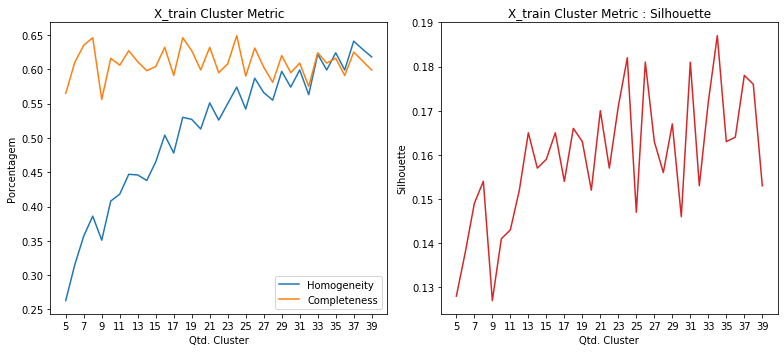

In [18]:
df_cluster = pd.DataFrame(clusterizacao, columns=["Qtd. Cluster", "Homogeneity", "Completeness", "Silhouette"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Homogeneity"], label="Homogeneity")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Completeness"], label="Completeness")
plt.xticks(range(kmin, kmax, 2))
plt.title("X_train Cluster Metric")
plt.xlabel("Qtd. Cluster")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Silhouette"], c="C3")
plt.xticks(range(kmin, kmax, 2))
plt.title("X_train Cluster Metric : Silhouette")
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

### HDBSCAN no espaço dos dados

In [19]:
clusterer_ = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
assigned_clusters = clusterer_.fit_predict(pairwise_distances(X.astype(np.float64), metric="cosine"))
assigned_clusters = join_cluster(X, assigned_clusters)
qtd_cluster = len(list(set(assigned_clusters)))

docs = np.asarray(X_train)

info = []
frases = []
for i in range(qtd_cluster):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(qtd_cluster)], np.asarray(info)[:, 1]])
print("Frases por cluster:")
data = []
for i in range(qtd_cluster):
    T = df.to_numpy()
    data += utils.shuffle(T[T[:, 1] == i], n_samples=3).tolist()
df = pd.DataFrame(data, columns=["title", "cluster"])
display(HTML(df.sort_values(by=["cluster"]).to_html(index=False)))

print("-" * 20)
print("Documentos por cluster:")
display(HTML(df_inf.to_html(index=False, header=False)))

Frases por cluster:


title,cluster
Essa não é a instrução que me deram. Me mandaram um novo chip e me mandaram transferir meu velho número da outra operadora,0
Posso transferir meus dados quando troco telefones?,0
Como trocar um plano de conversação direta para um telefone desta operadora gratuitamente?,0
"Se eu recarregar R$ 50, o que eu ganho?",1
Quanto preciso pagar para ativar meu plano pré-pago?,1
"Por favor, eu preciso de uma maneira fácil de recarregar.",1
"Se eu mudar um proveder, o que acontecerá com o meu número atual?",2
"Quanto tempo eu tenho para devolver o telefone, se eu mudar de ideia?",2
Você poderia me ajudar em como mudar o toque do meu telefone?,2
posso fazer a configuracao em meu so sem usar a informacao de certificado digital disponibilizada?,3


--------------------
Documentos por cluster:


C0,6
C1,7
C2,11
C3,12
C4,8
C5,6
C6,6
C7,6
C8,13
C9,12
C10,9


### Topologia dos dados de treinamento usando MDS

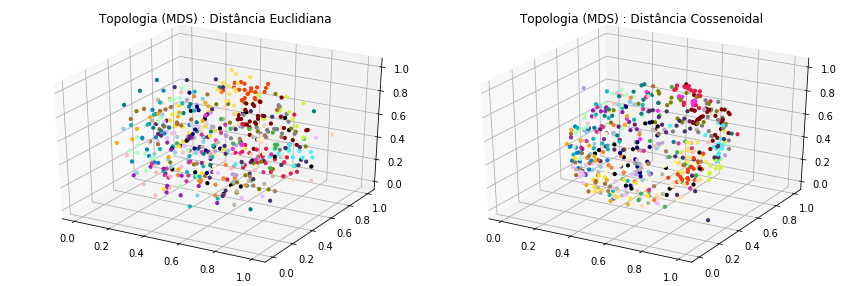

In [20]:
X_cnt = MDS(
    n_components=3,
    n_init=10,
    max_iter=1500,
    random_state=0,
    n_jobs=-1
).fit_transform(X.astype(np.float64))
X_cnt = MinMaxScaler().fit_transform(X_cnt)

X_cnt2 = MDS(
    n_components=3,
    n_init=10,
    max_iter=1500,
    dissimilarity="precomputed",
    random_state=0
).fit_transform(pairwise_distances(X.astype(np.float64), metric="cosine"))
X_cnt2 = MinMaxScaler().fit_transform(X_cnt2)

c_y_train, c_y_cluster = make_colors(y_train, y_train, colors)

plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title("Topologia (MDS) : Distância Euclidiana")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_train, alpha=1, s=10)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title("Topologia (MDS) : Distância Cossenoidal")
ax.scatter(X_cnt2[:, 0], X_cnt2[:, 1], X_cnt2[:, 2], c=c_y_cluster, alpha=1, s=10)
plt.tight_layout()
plt.show()

## **HDBSCAN**

 - [How HDBSCAN Works](https://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/How%20HDBSCAN%20Works.ipynb)
 - [hdbscan github implementation](https://github.com/scikit-learn-contrib/hdbscan)
 - [Density-Based Clustering Based on Hierarchical Density Estimates](https://link.springer.com/chapter/10.1007/978-3-642-37456-2_14)

---

## **t-SNE + HDBSCAN**

In [21]:
def calculate_tsne(X, perp):
    lr = int(np.mean(np.random.randint(10, 300, 5)))
    angle = np.max(np.round(np.random.uniform(0.5, 0.9, 5), 2))
    
    X_cnt_ = TSNE(
        n_components=3,
        init="pca",
        learning_rate=lr,
        perplexity=perp,
        angle=angle,
        metric="cosine",
        method="exact",
        n_iter=5000,
        n_iter_without_progress=1000,
        random_state=0
    ).fit_transform(X)
    X_cnt_ = MinMaxScaler().fit_transform(X_cnt_)
    
    clusterer_ = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
    cluster_labels_ = clusterer_.fit_predict(pairwise_distances(X_cnt_.astype(np.float64), metric="cosine"))
    cluster_labels_ = join_cluster(X_cnt_, cluster_labels_)   

    hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, cluster_labels_)
    silh = silhouette_score(X_cnt_, labels=cluster_labels_, metric="cosine", random_state=0)
    return {
        "POINTS": X_cnt_,
        "CLUSTERS": cluster_labels_,
        "ANGLE": angle,
        "LEARNING_RATE": lr,
        "PERP": perp,
        "HOM": hom,
        "COMPL": compl,
        "VMEN": v_measure,
        "SILH": silh
    }

clusterizacao = []
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    results = list(exc.map(partial(calculate_tsne, X), range(5, 61, 1), chunksize=10))
    for r in results:   
        clusterizacao.append({
            "Points": r["POINTS"],
            "Clusters": r["CLUSTERS"],
            "Perplexity": r["PERP"],
            "Learning Rate": r["LEARNING_RATE"],
            "Angle": r["ANGLE"],
            "Homogeneity": np.round(r["HOM"], 3),
            "Completeness": np.round(r["COMPL"], 3),
            "V-Measure": np.round(r["VMEN"], 3),
            "Silhouette": np.round(r["SILH"], 3)
        })

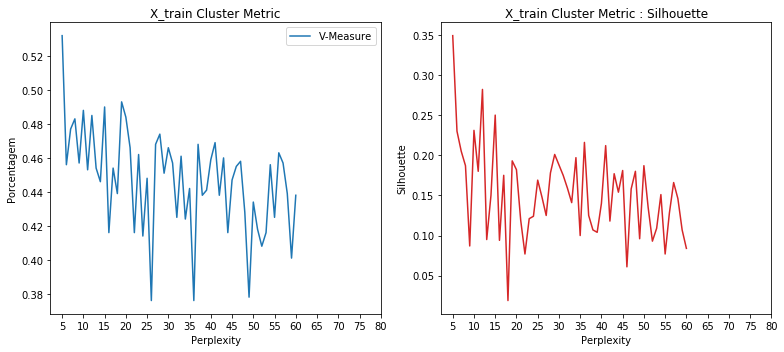

In [22]:
df_cluster = pd.DataFrame(clusterizacao, columns=["Perplexity", "Learning Rate", "Angle", "V-Measure", "Silhouette"]).sort_values(by=["Perplexity"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster["Perplexity"], df_cluster["V-Measure"], label="V-Measure")
plt.xticks(range(5, 81, 5))
plt.title("X_train Cluster Metric")
plt.xlabel("Perplexity")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster["Perplexity"], df_cluster["Silhouette"], c="C3")
plt.xticks(range(5, 81, 5))
plt.title("X_train Cluster Metric : Silhouette")
plt.xlabel("Perplexity")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

In [23]:
perp, lr, angle = df_cluster[df_cluster["Silhouette"] == np.max(df_cluster["Silhouette"])][["Perplexity", "Learning Rate", "Angle"]].to_numpy()[0]
df_cluster.sort_values(by=["Silhouette"], ascending=False)[:25]

,Perplexity,Learning Rate,Angle,V-Measure,Silhouette
0,5,125,0.87,0.532,0.349
7,12,186,0.79,0.485,0.282
10,15,125,0.87,0.490,0.250
5,10,127,0.67,0.488,0.231
1,6,276,0.85,0.456,0.230
31,36,276,0.85,0.376,0.216
36,41,140,0.83,0.469,0.212
2,7,129,0.84,0.477,0.205
24,29,161,0.86,0.451,0.201
29,34,215,0.76,0.424,0.197


Homogeneidade    :  0.541
Completude       :  0.523
V-Measure        :  0.532
Silhouette       :  0.349


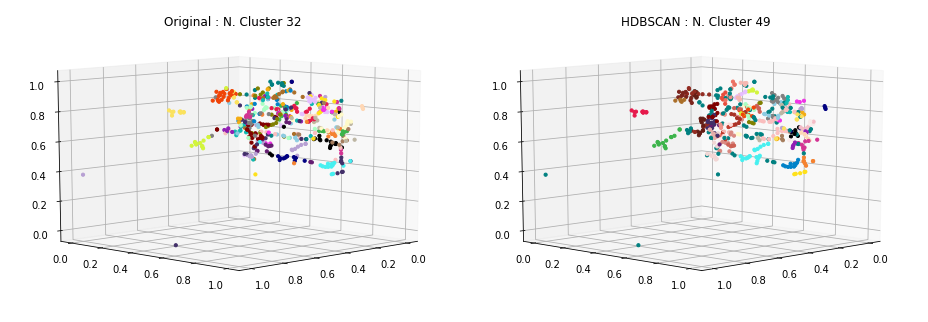

In [24]:
X_cnt = TSNE(
    n_components=3,
    init="pca",
    learning_rate=lr,
    perplexity=perp,
    angle=angle,
    metric="cosine",
    method="exact",
    n_iter=5000,
    n_iter_without_progress=1000,
    random_state=0
).fit_transform(X)
X_cnt = MinMaxScaler().fit_transform(X_cnt)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(pairwise_distances(X_cnt.astype(np.float64), metric="cosine"))
cluster_labels = join_cluster(X_cnt, cluster_labels)
c_y_train, c_y_cluster = make_colors(y_train, cluster_labels, colors)

hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, cluster_labels)
silh = silhouette_score(X_cnt, labels=cluster_labels, metric="cosine", random_state=0)

print("Homogeneidade    : ", np.round(hom, 3))
print("Completude       : ", np.round(compl, 3))
print("V-Measure        : ", np.round(v_measure, 3))
print("Silhouette       : ", np.round(silh, 3))

plt.figure(figsize=(13, 9))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title(f"Original : N. Cluster {len(set(y_train))}")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_train, alpha=1, s=10)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title(f"HDBSCAN : N. Cluster {len(set(cluster_labels))}")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_cluster, alpha=1, s=10)
ax.view_init(10, 45)
plt.tight_layout()
plt.show()

In [25]:
qtd_clusters = len(set(cluster_labels))
docs = np.asarray(X_train)

info = []
frases = []
for i in range(qtd_clusters):
    idx = np.where(cluster_labels == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(qtd_clusters)], np.asarray(info)[:, 1]])

print("Frases por cluster:")
data = []
for i in range(qtd_clusters):
    T = df.to_numpy()
    data += utils.shuffle(T[T[:, 1] == i], n_samples=3).tolist()
df = pd.DataFrame(data, columns=["title", "cluster"])
display(HTML(df.sort_values(by=["cluster"]).to_html(index=False)))

print("-" * 20)
print("Documentos por cluster:")
display(HTML(df_inf.to_html(index=False, header=False)))

Frases por cluster:


title,cluster
how to configure vpn?,0
gostaria de utilizar a vpn da empresa,0
voce nao sabe nada sobre vpn?,0
quero mais informacoes sobre senhas e como proceder,1
Solicitação de certificado digital,1
quero revogar meu certificado digital emitido para meu sistema,1
"ainda estou com dificuldades, um bot não pode resolver meu problema",2
"Você não resolveu meu problema, quero falar com um humano",2
"voce nao conseguiu me ajudar, quero falar com um atendente",2
eu nao gosto de falar com chatbots,3


--------------------
Documentos por cluster:


C0,10
C1,15
C2,5
C3,10
C4,7
C5,6
C6,20
C7,6
C8,8
C9,28
C10,100


---

## **Spectral Embedding + HDBSCAN**

In [26]:
def calculate_spec_emb(X, gamma):
    X_cnt_ = SpectralEmbedding(
        n_components=3,
        affinity="rbf",
        gamma=gamma,
        n_neighbors=5,
        random_state=0
    ).fit_transform(X)
    X_cnt_ = MinMaxScaler().fit_transform(X_cnt_)
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
    cluster_labels_ = clusterer.fit_predict(pairwise_distances(X_cnt_.astype(np.float64), metric="cosine"))
    cluster_labels_ = join_cluster(X_cnt_, cluster_labels_)
    
    hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, cluster_labels_)
    silh = silhouette_score(X_cnt_, labels=cluster_labels_, metric="cosine", random_state=0)
    return {
        "POINTS": X_cnt_,
        "CLUSTERS": cluster_labels_,
        "GAMMA": gamma,
        "HOM": hom,
        "COMPL": compl,
        "VMEN": v_measure,
        "SILH": silh
    }

clusterizacao_sp = []
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    results = list(exc.map(partial(calculate_spec_emb, X), np.round(np.random.uniform(0.2, 0.9, 20), 2), chunksize=10))
    for r in results:   
        clusterizacao_sp.append({
            "Points": r["POINTS"],
            "Clusters": r["CLUSTERS"],
            "Gamma": r["GAMMA"],
            "Homogeneity": np.round(r["HOM"], 3),
            "Completeness": np.round(r["COMPL"], 3),
            "V-Measure": np.round(r["VMEN"], 3),
            "Silhouette": np.round(r["SILH"], 3)
        })

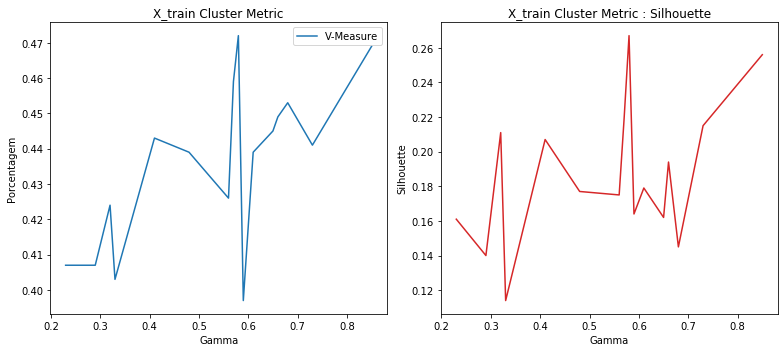

In [27]:
df_cluster_sp = pd.DataFrame(clusterizacao_sp, columns=["Gamma", "V-Measure", "Silhouette"]).sort_values(by=["Gamma"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster_sp["Gamma"], df_cluster_sp["V-Measure"], label="V-Measure")
plt.title("X_train Cluster Metric")
plt.xlabel("Gamma")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster_sp["Gamma"], df_cluster_sp["Silhouette"], c="C3")
plt.title("X_train Cluster Metric : Silhouette")
plt.xlabel("Gamma")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

In [28]:
gamma = df_cluster_sp[df_cluster_sp["Silhouette"] == np.max(df_cluster_sp["Silhouette"])]["Gamma"].to_numpy()[0]
df_cluster_sp.sort_values(by=["Silhouette"], ascending=False)[:25]

,Gamma,V-Measure,Silhouette
10,0.58,0.472,0.267
12,0.85,0.469,0.256
18,0.57,0.459,0.219
16,0.57,0.459,0.219
13,0.73,0.441,0.215
4,0.32,0.424,0.211
11,0.32,0.424,0.211
2,0.32,0.424,0.211
9,0.41,0.443,0.207
19,0.66,0.449,0.194


Homogeneidade    :  0.477
Completude       :  0.468
V-Measure        :  0.472
Silhouette       :  0.267


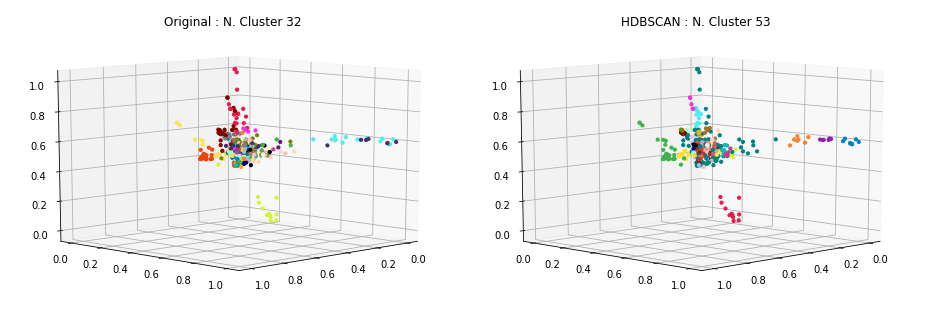

In [29]:
X_cnt = SpectralEmbedding(
    n_components=3,
    affinity="rbf",
    gamma=gamma,
    n_neighbors=5,
    random_state=0
).fit_transform(X)
X_cnt = MinMaxScaler().fit_transform(X_cnt)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(pairwise_distances(X_cnt.astype(np.float64), metric="cosine"))
cluster_labels = join_cluster(X_cnt, cluster_labels)
c_y_train, c_y_cluster = make_colors(y_train, cluster_labels, colors)

# clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
# cluster_labels = clusterer.fit_predict(X_cnt)

hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, cluster_labels)
silh = silhouette_score(X_cnt, labels=cluster_labels, metric="cosine", random_state=0)
# silh = silhouette_score(X_cnt, labels=cluster_labels, random_state=0)

print("Homogeneidade    : ", np.round(hom, 3))
print("Completude       : ", np.round(compl, 3))
print("V-Measure        : ", np.round(v_measure, 3))
print("Silhouette       : ", np.round(silh, 3))

plt.figure(figsize=(13, 9))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title(f"Original : N. Cluster {len(set(y_train))}")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_train, alpha=1, s=10)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title(f"HDBSCAN : N. Cluster {len(set(cluster_labels))}")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_cluster, alpha=1, s=10)
ax.view_init(10, 45)
plt.tight_layout()
plt.show()

---

## **MDS + HDBSCAN**

In [30]:
def calculate_mds(X, iteration):
    init = np.random.randint(5, 50)
    X_cnt_ = MDS(
        n_components=3,
        n_init=init,
        max_iter=iteration,
        dissimilarity="precomputed",
        random_state=0
    ).fit_transform(pairwise_distances(X.astype(np.float64), metric="cosine"))
    X_cnt_ = MinMaxScaler().fit_transform(X_cnt_)
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
    cluster_labels_ = clusterer.fit_predict(pairwise_distances(X_cnt_.astype(np.float64), metric="cosine"))
    cluster_labels_ = join_cluster(X_cnt_, cluster_labels_)
    
    hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, cluster_labels_)
    silh = silhouette_score(X_cnt_, labels=cluster_labels_, metric="cosine", random_state=0)
    return {
        "POINTS": X_cnt_,
        "CLUSTERS": cluster_labels_,
        "INIT": init,
        "ITER": iteration,
        "HOM": hom,
        "COMPL": compl,
        "VMEN": v_measure,
        "SILH": silh
    }

clusterizacao_sp = []
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    results = list(exc.map(partial(calculate_mds, X), range(500, 5000, 100), chunksize=10))
    for r in results:   
        clusterizacao_sp.append({
            "Points": r["POINTS"],
            "Clusters": r["CLUSTERS"],
            "N_Init": r["INIT"],
            "Iterações": r["ITER"],
            "Homogeneity": np.round(r["HOM"], 3),
            "Completeness": np.round(r["COMPL"], 3),
            "V-Measure": np.round(r["VMEN"], 3),
            "Silhouette": np.round(r["SILH"], 3)
        })

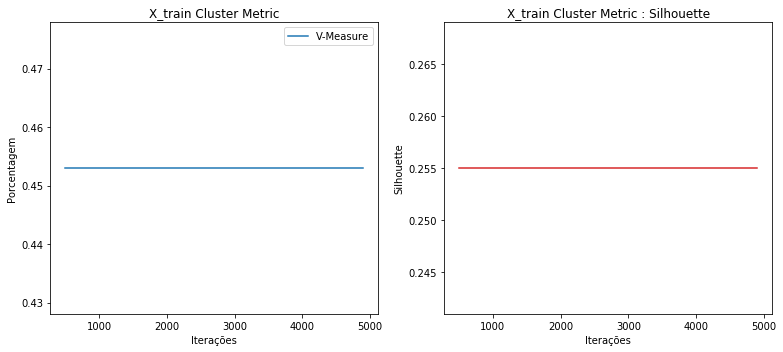

In [31]:
df_cluster_sp = pd.DataFrame(clusterizacao_sp, columns=["Iterações", "N_Init", "V-Measure", "Silhouette"]).sort_values(by=["Iterações"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster_sp["Iterações"], df_cluster_sp["V-Measure"], label="V-Measure")
plt.title("X_train Cluster Metric")
plt.xlabel("Iterações")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster_sp["Iterações"], df_cluster_sp["Silhouette"], c="C3")
plt.title("X_train Cluster Metric : Silhouette")
plt.xlabel("Iterações")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

In [32]:
iterations, init = df_cluster_sp[df_cluster_sp["Silhouette"] == np.max(df_cluster_sp["Silhouette"])][["Iterações", "N_Init"]].to_numpy()[0]
df_cluster_sp.sort_values(by=["Silhouette"], ascending=False)[:25]

,Iterações,N_Init,V-Measure,Silhouette
0,500,19,0.453,0.255
23,2800,18,0.453,0.255
25,3000,17,0.453,0.255
26,3100,12,0.453,0.255
27,3200,34,0.453,0.255
28,3300,20,0.453,0.255
29,3400,11,0.453,0.255
30,3500,19,0.453,0.255
31,3600,16,0.453,0.255
32,3700,42,0.453,0.255


Homogeneidade    :  0.464
Completude       :  0.441
V-Measure        :  0.453
Silhouette       :  0.255


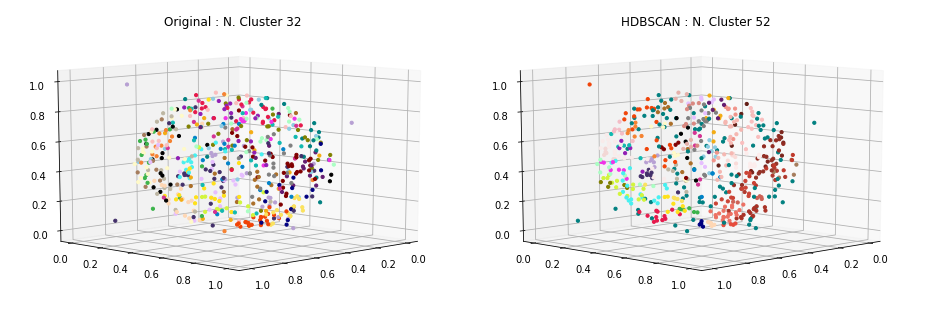

In [33]:
X_cnt = MDS(
    n_components=3,
    n_init=init,
    max_iter=iterations,
    dissimilarity="precomputed",
    random_state=0
).fit_transform(pairwise_distances(X.astype(np.float64), metric="cosine"))
X_cnt = MinMaxScaler().fit_transform(X_cnt)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed", gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(pairwise_distances(X_cnt.astype(np.float64), metric="cosine"))
cluster_labels = join_cluster(X_cnt, cluster_labels)
c_y_train, c_y_cluster = make_colors(y_train, cluster_labels, colors)

# clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
# cluster_labels = clusterer.fit_predict(X_cnt)

hom, compl, v_measure = homogeneity_completeness_v_measure(y_train, cluster_labels)
silh = silhouette_score(X_cnt, labels=cluster_labels, metric="cosine", random_state=0)
# silh = silhouette_score(X_cnt, labels=cluster_labels, random_state=0)

print("Homogeneidade    : ", np.round(hom, 3))
print("Completude       : ", np.round(compl, 3))
print("V-Measure        : ", np.round(v_measure, 3))
print("Silhouette       : ", np.round(silh, 3))

plt.figure(figsize=(13, 9))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title(f"Original : N. Cluster {len(set(y_train))}")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_train, alpha=1, s=10)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title(f"HDBSCAN : N. Cluster {len(set(cluster_labels))}")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=c_y_cluster, alpha=1, s=10)
ax.view_init(10, 45)
plt.tight_layout()
plt.show()